# Input Distribution Analysis

We have prompt, rejected, chosen. All can be multiple times, only tuples <prompt, rejected, chosen> is "really" unique.

## Data Loading

In [120]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [121]:
whole_df = pd.read_parquet('data_analysis/agent_prompt_cleaned.parquet')
train_df = pd.read_parquet('data_analysis/agent_train.parquet')
test_df = pd.read_parquet('data_analysis/agent_test.parquet')

## Plot styling

In [122]:
def style_wrapper(
        axis, title=None, x_label=None, y_label=None, show_legend=True,
        x_start_at_zero=True
):
    """
    Custom styling for matplotlib axis. Removes the upper and right spines, the remaining two
    have a thicker line. Adds horizontal grid lines. If x_start_at_zero is True, the x-axis starts at 0.
    """
    # Increase left and bottom spine thickness
    for spine in ['left', 'bottom']:
        axis.spines[spine].set_linewidth(2)

    # Remove top and right spine
    for spine in ['top', 'right']:
        axis.spines[spine].set_visible(False)

    # Increase axis tick thickness
    axis.tick_params(axis='both', width=2)

    # Add horizontal grid below data markers
    axis.yaxis.grid(True, linewidth=1)
    axis.set_axisbelow(True)

    # Set x-axis start at 0
    if x_start_at_zero:
        axis.set_xlim(left=0)

    # Set titles/axis labels
    if title:
        axis.set_title(title)
    if x_label:
        axis.set_xlabel(x_label)
    if y_label:
        axis.set_ylabel(y_label)

    # Toggle legend
    if show_legend:
        axis.legend()

## Dataset Size

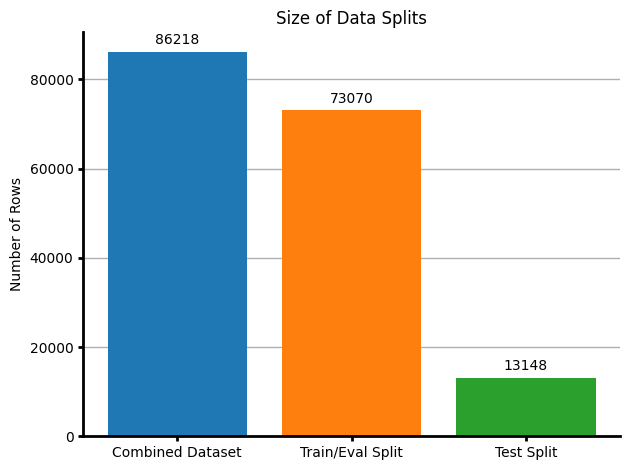

In [123]:
dfs = {'Combined Dataset': whole_df, 'Train/Eval Split': train_df, 'Test Split': test_df}

names = list(dfs.keys())
sizes = [len(df) for df in dfs.values()]

fig, ax = plt.subplots()
bars = ax.bar(names, sizes, color=['tab:blue', 'tab:orange', 'tab:green'])

for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords='offset points',
                ha='center', va='bottom')

style_wrapper(ax, title='Size of Data Splits',
              y_label='Number of Rows', show_legend=False,
              x_start_at_zero=False)

plt.tight_layout()
plt.show()

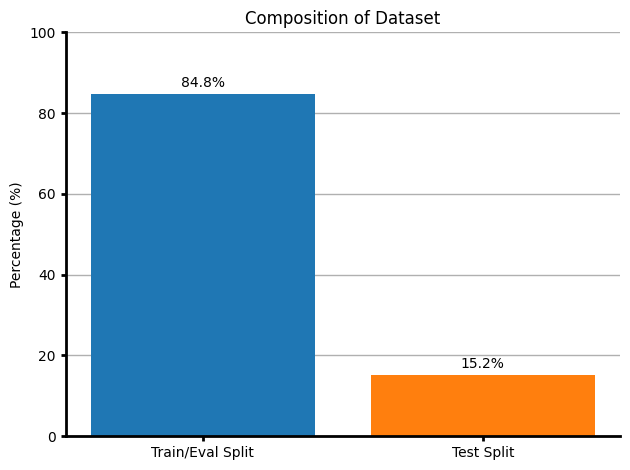

In [124]:
total = len(dfs['Combined Dataset'])
percent_train = len(dfs['Train/Eval Split']) / total * 100
percent_test = len(dfs['Test Split']) / total * 100

# Plotting
_, ax = plt.subplots()
bars = ax.bar(['Train/Eval Split', 'Test Split'], [percent_train, percent_test],
              color=['tab:blue', 'tab:orange'])

# Add percentage labels
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords='offset points',
                ha='center', va='bottom')

ax.set_ylim(0, 100)

style_wrapper(ax, title='Composition of Dataset',
              y_label='Percentage (%)', show_legend=False,
              x_start_at_zero=False)

plt.tight_layout()
plt.show()

The train/test split was performed on categories. From the raw dataset, 8 categories were randomly picked and extracted from the train dataset. This was performed in such a manner, that the resulting test dataset contains at least 1000 unique prompts. This way, the evaluation will be performed on previously unseen tasks, which should show how well the model generalizes.

## Prompt Count

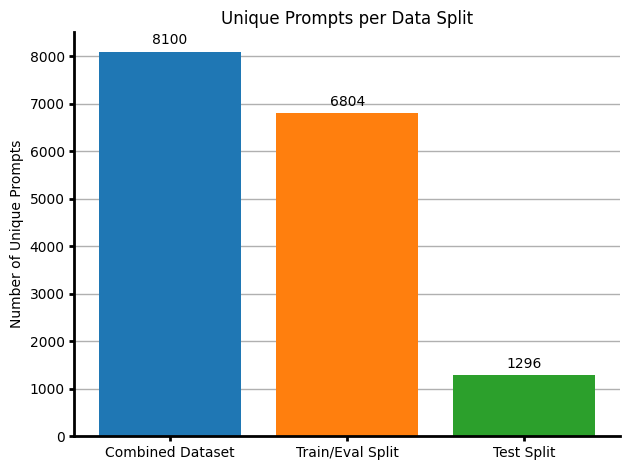

In [125]:
names = list(dfs.keys())
sizes = [df['prompt'].nunique() for df in dfs.values()]

fig, ax = plt.subplots()
bars = ax.bar(names, sizes,color=['tab:blue', 'tab:orange', 'tab:green'])

for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords='offset points',
                ha='center', va='bottom')

style_wrapper(ax, title='Unique Prompts per Data Split',
              y_label='Number of Unique Prompts', show_legend=False,
              x_start_at_zero=False)

plt.tight_layout()
plt.show()

## Prompt Distribution

In [126]:
def plot_prompt_distribution(df, title=None):
    """
    Shows a boxplot showing the distribution of unique chosen/rejected values per prompt.
    """

    prompt_counts = df['prompt'].value_counts()

    _, plot_ax = plt.subplots()
    plot_ax.boxplot(prompt_counts.values)
    style_wrapper(
        plot_ax, title=title, x_label=None,
        y_label='Frequency', show_legend=False, x_start_at_zero=True
    )

    # Center the box and remove tick label
    plot_ax.set_xticks([])
    plot_ax.set_xlim(0.5, 1.5)

    plt.tight_layout()
    plt.show()

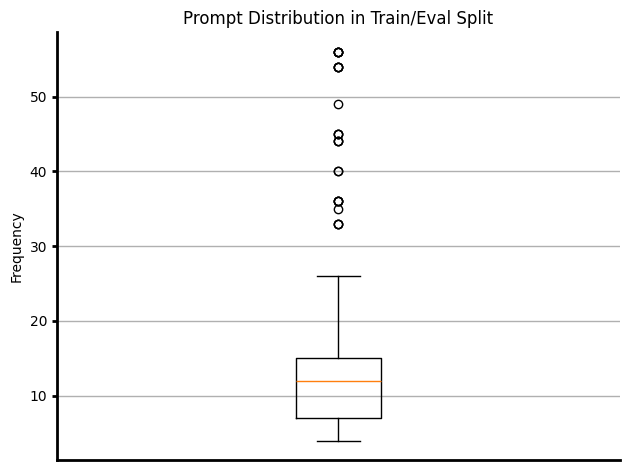

In [127]:
plot_prompt_distribution(train_df, title='Prompt Distribution in Train/Eval Split')

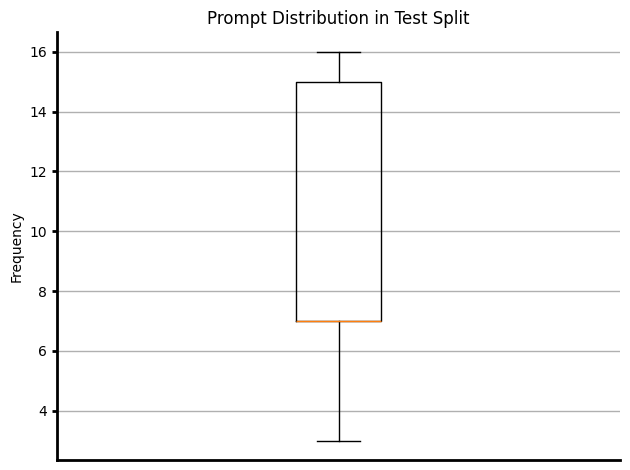

In [128]:
plot_prompt_distribution(test_df, title='Prompt Distribution in Test Split')

### Chosen/Rejected distributions

In [129]:
def plot_unique_response_distribution(df, title=None):
    """
    Shows a boxplot showing the distribution of unique chosen/rejected values per prompt.
    """

    # Calculate unique responses per prompt
    chosen_per_prompt = df.groupby('prompt')['chosen'].nunique()

    _, plot_ax = plt.subplots()
    plot_ax.boxplot(chosen_per_prompt.values)
    style_wrapper(
        plot_ax,
        title=title,
        x_label=None,
        y_label='Responses per Prompt',
        show_legend=False
    )

    # Center the box and remove tick label
    plot_ax.set_xticks([])
    plot_ax.set_xlim(0.5, 1.5)

    plt.tight_layout()
    plt.show()

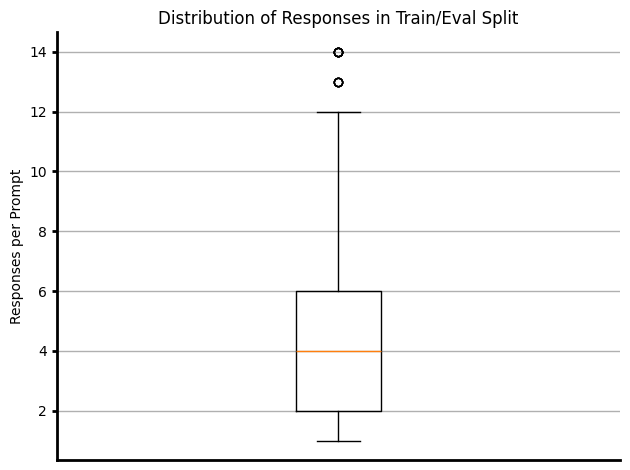

In [130]:
plot_unique_response_distribution(train_df, 'Distribution of Responses in Train/Eval Split')

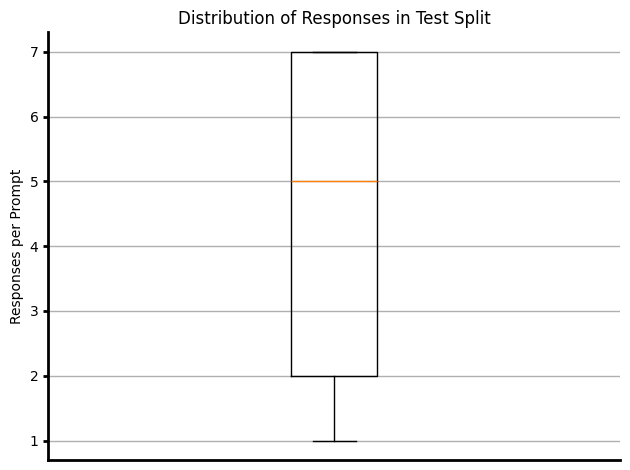

In [131]:
plot_unique_response_distribution(test_df, 'Distribution of Responses in Test Split')

## Per Category

In [171]:
def truncate_labels(labels, max_length=20):
    # Truncate labels to a given max length
    return [label if len(label) <= max_length else label[:max_length - 3] + '...' for label in labels]


def plot_top_categories(df, top_n=15, title=None):
    category_counts = df['category'].value_counts()
    top_categories = category_counts.head(top_n)

    truncated_labels = truncate_labels(top_categories.index.tolist())
    _, plot_ax = plt.subplots()
    plot_ax.bar(truncated_labels, top_categories.values, color='tab:blue')

    style_wrapper(
        plot_ax,
        title=title,
        x_label='Category',
        y_label='Number of Samples',
        show_legend=False,
        x_start_at_zero=False
    )

    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

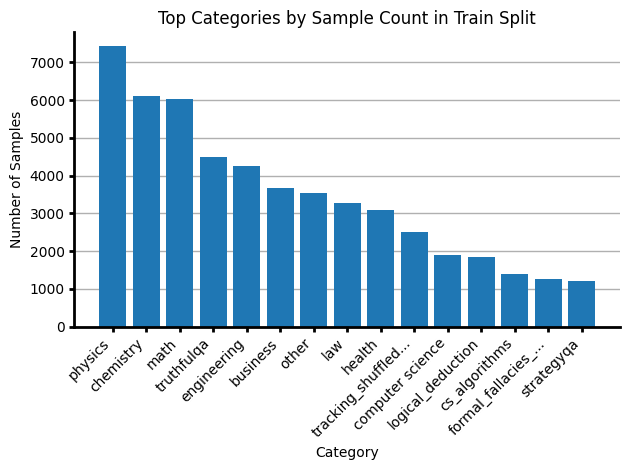

In [172]:
plot_top_categories(dfs['Train/Eval Split'], title='Top Categories by Sample Count in Train Split')

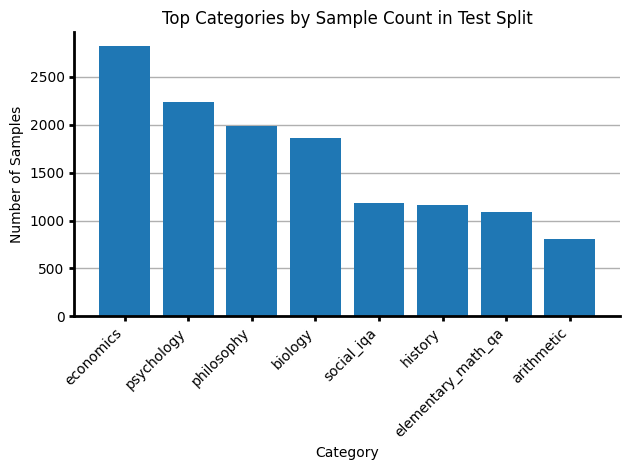

In [173]:
plot_top_categories(dfs['Test Split'], title='Top Categories by Sample Count in Test Split')

In [176]:
def plot_sample_count_boxplot(df, title=None):
    category_counts = df['category'].value_counts()
    _, plot_ax = plt.subplots()
    plot_ax.boxplot(category_counts.values)

    style_wrapper(
        plot_ax,
        title=title,
        x_label=None,
        y_label='Number of Samples per Category',
        show_legend=False,
        x_start_at_zero=True
    )

    # Center the box and remove tick label
    plot_ax.set_xticks([])
    plot_ax.set_xlim(0.5, 1.5)

    plt.tight_layout()
    plt.show()

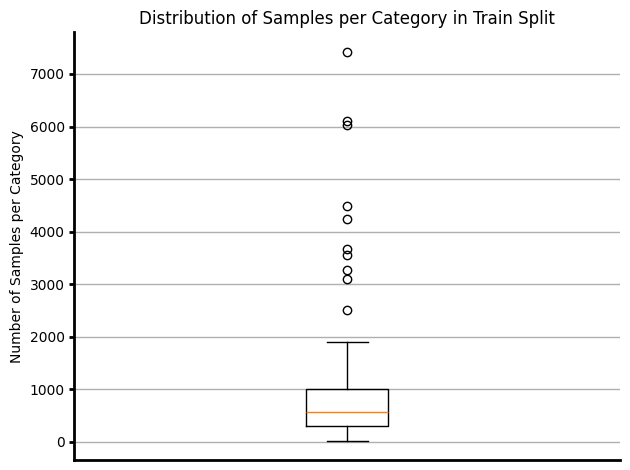

In [178]:
plot_sample_count_boxplot(dfs['Train/Eval Split'], title='Distribution of Samples per Category in Train Split')

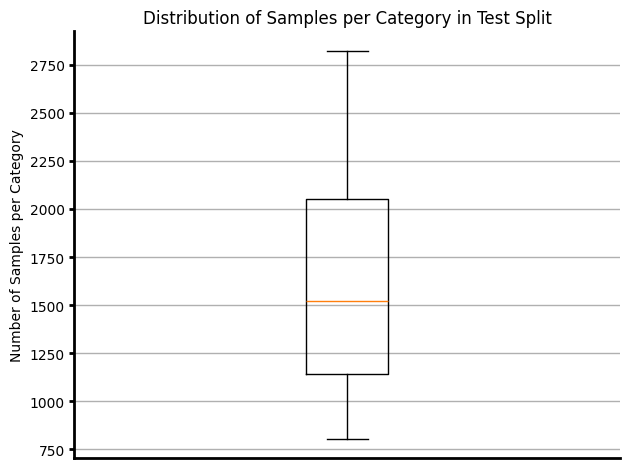

In [179]:
plot_sample_count_boxplot(dfs['Test Split'], title='Distribution of Samples per Category in Test Split')